In [1]:
import os

os.chdir("../..")
os.getcwd()

'/home/mario/PhD/spatial_lda'

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import subprocess
import pymc3 as pm
import seaborn as sns

from spatial_mix.utils import *
from spatial_mix.protos.py.univariate_mixture_state_pb2 import UnivariateState, UnivariateMixtureState, HdpState

current_palette = sns.color_palette()

In [3]:
covariates = ["host_is_superhost", "accommodates", "bathrooms", "bedrooms", 
              "number_of_reviews", "review_scores_rating", "instant_bookable"]

# Run

In [4]:
with open("data/amsterdam.pkl", "rb") as fp:
    datas = pickle.load(fp)

In [5]:
datas.keys()

dict_keys(['y', 'G', 'neigh_names', 'cov'])

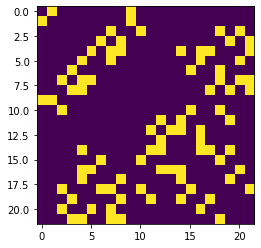

In [6]:
plt.imshow(datas["G"])

In [7]:
np.sum([len(x) for x in datas["y"]])

17201

In [8]:
cov_small = ["host_is_superhost", "accommodates",
              "number_of_reviews", "review_scores_rating", "instant_bookable"]

covariates_by_group = []
for i, cov in enumerate(datas["cov"]):      
    currDf = cov[cov_small].copy()
    if(currDf.isna().sum().sum()):
        print("Nans in group {0}".format(i))
    
    currDf["host_is_superhost"] = currDf["host_is_superhost"].apply(lambda x: int(x == "t"))
    currDf["instant_bookable"] = currDf["instant_bookable"].apply(lambda x: int(x == "t"))
    
    curr = currDf.values.astype(np.float)
    covariates_by_group.append(curr)

In [9]:
for i in range(len(datas["y"])):
    if len(datas["y"][i]) != len(datas["cov"][i]):
        print("error in ", i)
        print("datas: ", len(datas["y"][i]), " covariates", covariates_by_group[i].shape[0])

In [10]:
params = SamplerParams()
with open("spatial_mix/resources/sampler_params.asciipb", "r") as fp:
    text_format.Parse(fp.read(), params)
    
params

num_components: 5
p0_params {
  a: 2.0
  b: 2.0
  lam_: 0.1
}
rho_params {
  a: 1.0
  b: 5.0
}
sigma_params {
  nu: 100.0
  identity: true
}
mtilde_sigmasq: 5.0
linreg_params {
  prec: 0.1
  a: 2.0
  b: 2.0
}

In [11]:
chains, time = runSpatialMixtureSampler(
    5000, 5000, 5, datas["G"], 
    "spatial_mix/resources/sampler_params.asciipb",
    datas["y"], covariates_by_group)

# params = SamplerParams()
# with open("spatial_mix/resources/sampler_params.asciipb", "r") as fp:
#     text_format.Parse(fp.read(), params)

# chains, time = runDependentMixtureSampler(
#     5, 20, 2, datas["G"], 
#     "spatial_mix/resources/sampler_params.asciipb",
#     datas["y"], covariates_by_group)

num_components: 5
p0_params {
  a: 2.0
  b: 2.0
  lam_: 0.1
}
rho_params {
  a: 1.0
  b: 5.0
}
sigma_params {
  nu: 100.0
  identity: true
}
mtilde_sigmasq: 5.0
linreg_params {
  prec: 0.1
  a: 2.0
  b: 2.0
}

Burn-in, iter # 200  /  5000
Burn-in, iter # 400  /  5000
Burn-in, iter # 600  /  5000
Burn-in, iter # 800  /  5000
Burn-in, iter # 1000  /  5000
Burn-in, iter # 1200  /  5000
Burn-in, iter # 1400  /  5000
Burn-in, iter # 1600  /  5000
Burn-in, iter # 1800  /  5000
Burn-in, iter # 2000  /  5000
Burn-in, iter # 2200  /  5000
Burn-in, iter # 2400  /  5000
Burn-in, iter # 2600  /  5000
Burn-in, iter # 2800  /  5000
Burn-in, iter # 3000  /  5000
Burn-in, iter # 3200  /  5000
Burn-in, iter # 3400  /  5000
Burn-in, iter # 3600  /  5000
Burn-in, iter # 3800  /  5000
Burn-in, iter # 4000  /  5000
Burn-in, iter # 4200  /  5000
Burn-in, iter # 4400  /  5000
Burn-in, iter # 4600  /  5000
Burn-in, iter # 4800  /  5000
Burn-in, iter # 5000  /  5000
Running, iter # 200  /  5000
Running, iter #

In [14]:
eval_dens = None
resp = datas["y"]
for i in range(len(covariates_by_group)):
    curr_dens = eval_mixture_dens(
        resp[i], chains, covariates_by_group[i], i)
    if eval_dens is None:
        eval_dens = curr_dens
    else:
        eval_dens = np.hstack([eval_dens, curr_dens])

In [15]:
print(lpml(eval_dens))
print(waic(eval_dens) * (-2))

-92961.59122623995
185923.18605217832


In [20]:
(92441 - 92961) / 92441 * 100

-0.5625209593145899

In [ ]:
# writeChains(chains, "data/amsterdam_chains_dependent_H5_20210303.recordio")

# Posterior Plots

In [21]:
import arviz as az

In [22]:
chains = loadChains("data/amsterdam_chains_standardized_20200605.recordio")

In [92]:
numIters = len(chains)
out = []
num_components = chains[0].num_components

means_chain = np.vstack(
    [list(map(lambda x: x.mean, state.atoms)) for state in chains])

stdevs_chain = np.vstack(
    [list(map(lambda x: x.stdev, state.atoms)) for state in chains])

weights_chain = np.vstack(
        [state.groupParams[group].weights for state in chains])

regressor_chains = np.vstack(
    [state.regression_coefficients for state in chains])

means = np.einsum("ij,kj->ik", regressor_chains, covariates_by_group[0])[:, np.newaxis, :] + \
    means_chain[:, :, np.newaxis]

eval_normals = norm.pdf(y, means, stdevs_chain[:, :, np.newaxis])

In [93]:
eval_normals.shape

(5000, 5, 91)

In [80]:
np.einsum("ij,kj->ik", regressor_chains, covariates_by_group[0]).shape

(5000, 91)

In [84]:
means = np.einsum("ij,kj->ik", regressor_chains, covariates_by_group[0])[:, np.newaxis, :] + \
    means_chain[:, :, np.newaxis]
means.shape

(5000, 5, 91)

In [91]:
s = 102
i = 55
h = 1

print(means[s, h, i])
print(np.dot(regressor_chains[s, :], covariates_by_group[0][i, :]) + means_chain[s, h])

109.68423559631327
109.68423559631327


## Regression Coefficients

/home/mario/.local/lib/python3.8/site-packages/arviz/utils.py:653: UserWarning: Keyword argument credible_interval has been deprecated Please replace with hdi_prob
  warnings.warn(


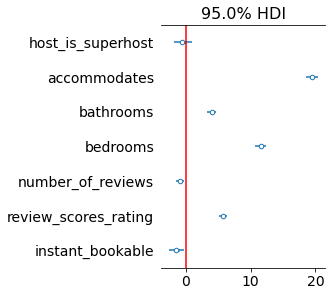

In [23]:
# fig, axes = fig, axes = plt.subplots(nrows=1 , ncols=1, figsize=(2.5, 3.5))

p_size = len(chains[0].regression_coefficients)
regressor_chains = {}
# covariates = ["intercept"] + covariates
for i, name in enumerate(covariates):
    regressor_chains[name] = np.array([c.regression_coefficients[i] for c in chains])

azChains = az.convert_to_inference_data(regressor_chains)
axes = az.plot_forest(azChains, credible_interval=0.95, figsize=(4.5, 4.0))
axes[0].axvline(color="red")
# plt.savefig("images/regression_coefficients_standardized_new.pdf")
plt.show()

## Couple of residual densities

In [24]:
def samplePredictiveRegression(chains, covariates, group):
    niter = len(chains)
    out = []
    num_comps = chains[0].num_components
    
    means_chain = np.vstack(
        [list(map(lambda x: x.mean, state.atoms)) for state in chains])

    stdevs_chain = np.vstack(
        [list(map(lambda x: x.stdev, state.atoms)) for state in chains])

    regressor_chains = np.vstack(
        [state.regression_coefficients for state in chains])

    weights_chains = np.vstack(
            [state.groupParams[group].weights for state in chains])
    
    preds = np.zeros(niter)
    for i in range(niter):
        means = np.dot(covariates, regressor_chains[i, :])
        cluster = np.apply_along_axis(
            lambda x: np.random.choice(range(num_comps), p=x), -1, 
            weights_chains[i, :])
        errs = norm.rvs(
            loc=means_chain[i, cluster], scale=stdevs_chain[i, cluster])
        preds[i] = means + errs
    
    return preds

In [55]:
def eval_dep_dens(xgrid, chains, covariates, group):
    means_chain = np.vstack(
        [list(map(lambda x: x.mean, state.atoms)) for state in chains])

    stdevs_chain = np.vstack(
        [list(map(lambda x: x.stdev, state.atoms)) for state in chains])

    weights_chain = np.vstack(
        [state.groupParams[group].weights for state in chains])

    regressor_chains = np.vstack(
        [state.regression_coefficients for state in chains])
    regmeans = np.einsum("ij,j->i", regressor_chains, covariates)
    means = regmeans[:, np.newaxis] + means_chain
    
    
    eval_normals = norm.pdf(xgrid[:, np.newaxis, np.newaxis], means[np.newaxis, :, :], 
                            stdevs_chain[np.newaxis, :, :])
    print("eval_normals: ", eval_normals.shape)
    eval_dens = np.sum(eval_normals * weights_chain[np.newaxis, :, :], axis=-1)
    return np.mean(eval_dens, axis=1)

In [27]:
import pandas as pd

df = pd.read_csv("data/amsterdam.csv")

eval_normals:  (500, 1000, 5)
eval_normals:  (500, 1000, 5)
eval_normals:  (500, 1000, 5)
eval_normals:  (500, 1000, 5)
eval_normals:  (500, 1000, 5)
eval_normals:  (500, 1000, 5)
eval_normals:  (500, 1000, 5)
eval_normals:  (500, 1000, 5)
eval_normals:  (500, 1000, 5)
eval_normals:  (500, 1000, 5)
eval_normals:  (500, 1000, 5)
eval_normals:  (500, 1000, 5)


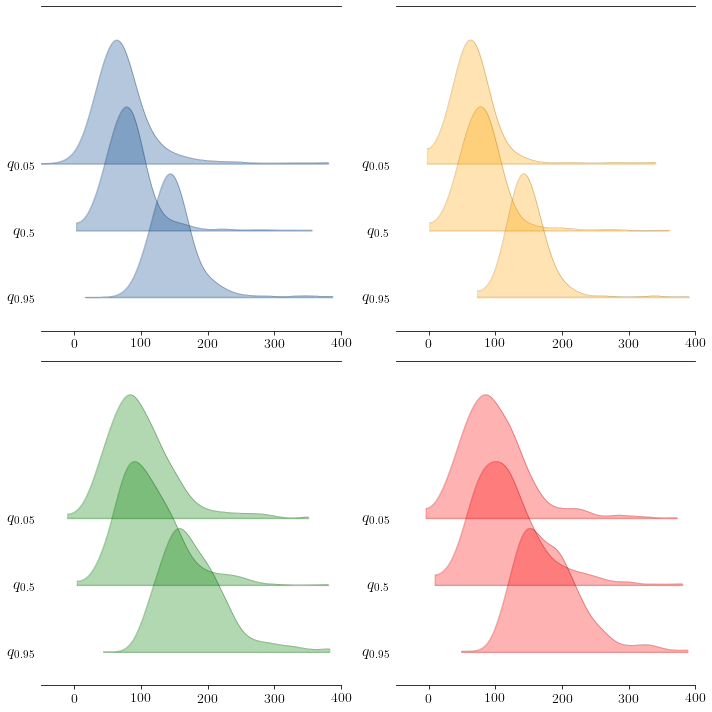

In [59]:
from matplotlib import rc
rc('text', usetex=True)
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14

fig, axes = plt.subplots(nrows=2 , ncols=2, figsize=(10, 10))
axes = axes.flat
toplot = [0, 9, 14, 19]


quantiles = [0.05, 0.5, 0.95]

plettes_by_neigh = [
    np.array(sns.color_palette("Blues", 10).as_hex())[np.array([3, 6, 9])],
    np.array(sns.light_palette("orange", 10).as_hex())[np.array([3, 6, 9])],
    np.array(sns.light_palette("green", 10).as_hex())[np.array([3, 6, 9])],
    np.array(sns.light_palette("red", 10).as_hex())[np.array([3, 6, 9])]
]

chains_basefile = "data/chains_mu0_{0}_a_{1}_b_{2}_lam{3}.recordio"

mu0 = 0.0
a = 0.5
b = 2.0
lamb = 0.5

chainfile = chains_basefile.format(mu0, a, b, lamb)

chains = loadChains(chainfile)


curr_covs = []
for q in quantiles:
    bedroom_group = [
    np.quantile(df.cov_1.values, q), np.quantile(df.cov_2.values, q),
    np.quantile(df.cov_3.values, q)
    ]
    curr_covs.append(
        np.concatenate([[0], bedroom_group, [np.quantile(df.cov_4, 0.5)], 
                        [np.quantile(df.cov_5, 0.6)], [1]]))

xgrid = np.linspace(0, 400, 500)
est_dens = []

for i in range(4):
    g = toplot[i]
    plot_data = {}
    for k, covs in enumerate(curr_covs):
        pred_samples = samplePredictiveRegression(chains, covs, g)
        pred_samples = pred_samples[np.where((pred_samples > -50) & (pred_samples < 400))[0]]
        plot_data[r"$q_{%s}$" % quantiles[k]] = pred_samples
        est_dens.append(eval_dep_dens(xgrid, chains, covs, g))
        
    
    az.plot_forest(
        plot_data,
        kind="ridgeplot",
        linewidth=0.1,
        combined=False,
        ridgeplot_alpha=0.3,
        ridgeplot_overlap=5,
        colors=plettes_by_neigh[i][2],
        ax=axes[i]
    )
    axes[i].set_xlim(-50, 400)
    

plt.tight_layout()
# plt.savefig("images/dens_est_bedrooms_square.pdf")
plt.show()

In [62]:
from scipy.integrate import trapz

def gt_200(xgrid, dens):
    wh = np.where(xgrid >= 200)
    return trapz(dens[wh], xgrid[wh])

for d in est_dens:
    print(gt_200(xgrid, d))

0.019739493221563285
0.022093505341850585
0.06574811183145032
0.015080583664561215
0.016877428073241753
0.05343620466958422
0.04780226154350571
0.05843814561338989
0.26766298841228825
0.04856419884233364
0.05937473725595257
0.2718557881412842


In [ ]:
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
fig, axes = plt.subplots(nrows=1 , ncols=1, figsize=(2.5, 3.5))


bedroom_group = [
    np.quantile(df.cov_1.values, q), np.quantile(df.cov_2.values, q),
    np.quantile(df.cov_3.values, q)
    ]

curr_covs = []
for q in [0.5, 0.5, 0.95]:
    curr_covs.append(
        np.concatenate([[0], bedroom_group, [np.quantile(df.cov_4, 0.5)], 
                        [np.quantile(df.cov_5, q)], [1]]))

    
chains_basefile = "data/chains_mu0_{0}_a_{1}_b_{2}_lam{3}.recordio"

mu0 = 0.0
a = 0.5
b = 2.0
lamb = 1.0

chainfile = chains_basefile.format(mu0, a, b, lamb)

g = 0
# plot_data = {}
# for k, covs in enumerate(curr_covs):
#     pred_samples = samplePredictiveRegression(chains, covs, g)
#     plot_data[r"$q_{%s}$" % quantiles[k]] = pred_samples
#     sns.kdeplot(pred_samples, color=plettes_by_neigh[g][k])
    
plot_data = {}
for k, covs in enumerate(curr_covs):
    pred_samples = samplePredictiveRegression(chains, covs, g)
    pred_samples = pred_samples[np.where((pred_samples > -50) & (pred_samples < 400))[0]]
    
    plot_data[r"$q_{%s}$" % quantiles[k]] = pred_samples

    
az.plot_forest(
    plot_data,
    kind="ridgeplot",
    linewidth=0.1,
    combined=False,
    ridgeplot_alpha=0.3,
    ridgeplot_overlap=5,
    colors=plettes_by_neigh[g][2],
    ax=axes
)
    
plt.xlim(-50, 400)
plt.tight_layout()
# plt.savefig("images/dens_est_reviews_new2.pdf")
plt.show()

## Sigma

In [ ]:
mat = np.triu(np.asarray(chains[i].Sigma.data).reshape(4, 4))
mat[np.nonzero(mat)]

In [ ]:
H = chains[0].num_components
sigmaChain = np.zeros((len(chains), int((H-1)*(H) / 2)))
for i in range(len(chains)):
    mat = np.triu(np.asarray(chains[i].Sigma.data).reshape(H-1, H-1))
    sigmaChain[i, :] = mat[np.nonzero(mat)]
    
azChain = az.convert_to_inference_data(sigmaChain[np.newaxis, :])
axes = az.plot_trace(azChain)
axes = axes.flat

axnum = 0
for i in range(H - 1):
    for j in range(i+1):
        axes[axnum].set_title("Sigma_[{0}, {1}]".format(i+1, j+1))
        axes[axnum+1].set_title("Sigma_[{0}, {1}]".format(i+1, j+1))
        axnum += 2
        
# plt.savefig("images/sigma_dens_trace_amsterdam_standardized.pdf")
plt.show()

## rho

In [ ]:
rhoChain = np.array([x.rho for x in chains])
    
azChain = az.convert_to_inference_data(rhoChain[np.newaxis, :])
axes = az.plot_trace(azChain)

# plt.savefig("images/rho_dens_trace_amsterdam_standardized.pdf")

In [ ]:
np.mean(rhoChain)

In [ ]:
np.std(rhoChain)

In [ ]:
from scipy.stats import norm

def mse(true_y, covs, areas, chains):
    niter = len(chains)
    preds = np.zeros((niter, len(true_y)))

    numGroups = len(chains[0].groupParams)
    num_components = chains[0].num_components

    means_chain = np.vstack(
        [list(map(lambda x: x.mean, state.atoms)) for state in chains])

    stdevs_chain = np.vstack(
        [list(map(lambda x: x.stdev, state.atoms)) for state in chains])

    regressor_chains = np.vstack(
        [state.regression_coefficients for state in chains])


    weights_chains = []
    for g in range(numGroups):
        weights_chains.append(np.vstack(
            [state.groupParams[g].weights for state in chains]))
    weights_chains = np.stack(weights_chains, axis=-1)

    for i in range(niter):
        means = np.dot(covs, regressor_chains[i, :])
        clusters = np.apply_along_axis(lambda x: np.random.choice(
            range(10), p=x), -1, weights_chains[i, :, areas])
        errs = norm.rvs(
            loc=means_chain[i, clusters], scale=stdevs_chain[i, clusters])
        preds[i, :] = means + errs

    predmean = np.mean(preds, axis=0)
    return np.sum((predmean - true_y)) ** 2

In [ ]:
mse(datas["y"][0], covariates_by_group[0], np.ones(len(datas["y"][0]), dtype=np.int32)  * 10, chains)

In [ ]:
mse(datas["y"][0], covariates_by_group[0], np.zeros(len(datas["y"][0]), dtype=np.int32), chains)

## Create DataFrame for CrossValidation

In [ ]:
import pandas as pd

df = None
colnames = ["group", "response"] + ["cov_{0}".format(i) for i in range(covariates_by_group[0].shape[1])]
for i in range(len(datas["y"])):
    group = np.ones(len(datas["y"][i])) * i
    currDf = np.hstack([
        group.reshape(-1, 1), 
        datas["y"][i].reshape(-1, 1), 
        covariates_by_group[i]])
    currDf = pd.DataFrame(currDf, columns=colnames)
    if df is None:
        df = currDf
    else:
        df = pd.concat([df, currDf])

In [ ]:
df.to_csv("data/amsterdam.csv")

In [ ]:
np.savetxt("data/gmat.txt", datas["G"])

# boxplots

In [105]:
import pickle
import pandas as pd

with open("data/cross_val.pickle", "rb") as fp:
    cross_val_scores = pickle.load(fp)

In [106]:
import matplotlib
import matplotlib.colors as mcolors

colors = [
    matplotlib.colors.to_rgba(mcolors.CSS4_COLORS["steelblue"]),
    matplotlib.colors.to_rgba(mcolors.CSS4_COLORS["orange"]), 
    matplotlib.colors.to_rgba(mcolors.CSS4_COLORS["green"]),
    matplotlib.colors.to_rgba(mcolors.CSS4_COLORS["red"])]

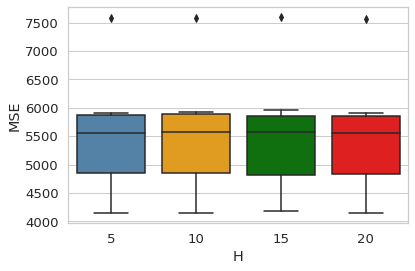

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt

cv_df = pd.DataFrame(cross_val_scores)
cv_df = pd.melt(cv_df)
cv_df.columns = ["H", "MSE"]

sns.set(font_scale=1.2)
sns.set_style("whitegrid")
sns.boxplot(x="H", y="MSE", data=cv_df, palette=colors)
plt.tight_layout()
# plt.savefig("mse_boxplots.pdf")

In [116]:
H=15
vals = cv_df[cv_df["H"] == H].MSE.values
print(np.mean(vals), np.std(vals))

5477.514261331127 956.1968323165464


In [2]:
-5  +10 / 6

-3.333333333333333